In [1]:
import pandas as pd
from numpy import nan
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Perceptron
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [2]:
# read the file and change it into dic
with open('./diabetes.txt') as f:
    lines = f.readlines()
    data = []
    for line in lines:
        parts = line.strip().split()
        label = int(parts[0])
        feature_dict = {int(i.split(':')[0]) : float(i.split(':')[1]) for i in parts[1:]}
        feature_dict['label'] = label
        data.append(feature_dict)

In [3]:
# change dic to dataframe
df = pd.DataFrame(data)

In [4]:
#check the data
df.head(5)

,1,2,3,4,5,6,7,8,label
0,6.0,148.0,72.0,35.0,0.0,33.599998,0.627,50.0,-1
1,1.0,85.0,66.0,29.0,0.0,26.600000,0.351,31.0,1
2,8.0,183.0,64.0,0.0,0.0,23.299999,0.672,32.0,-1
3,1.0,89.0,66.0,23.0,94.0,28.100000,0.167,21.0,1
4,0.0,137.0,40.0,35.0,168.0,43.099998,2.288,33.0,-1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       768 non-null    float64
 1   2       768 non-null    float64
 2   3       768 non-null    float64
 3   4       768 non-null    float64
 4   5       768 non-null    float64
 5   6       768 non-null    float64
 6   7       768 non-null    float64
 7   8       768 non-null    float64
 8   label   768 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 54.1 KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


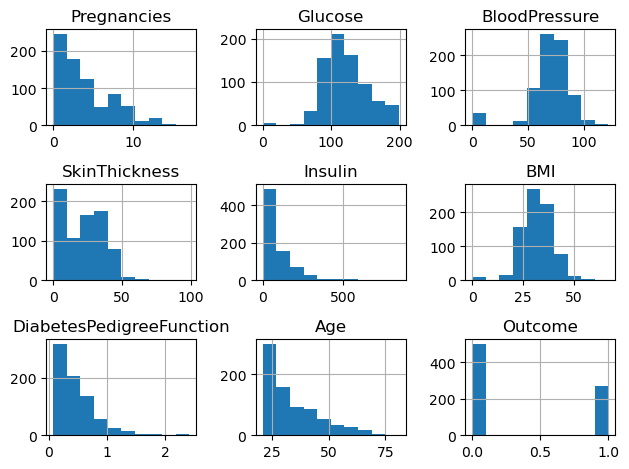

In [6]:
#check original dataset
origin_data = pd.read_csv('./diabetes.csv')
origin_data.info()
origin_data.hist()
plt.tight_layout()
plt.show()

In [7]:
# change label
df.loc[(df['label']==1), 'label'] = 0
df.loc[(df['label']==-1), 'label'] = 1

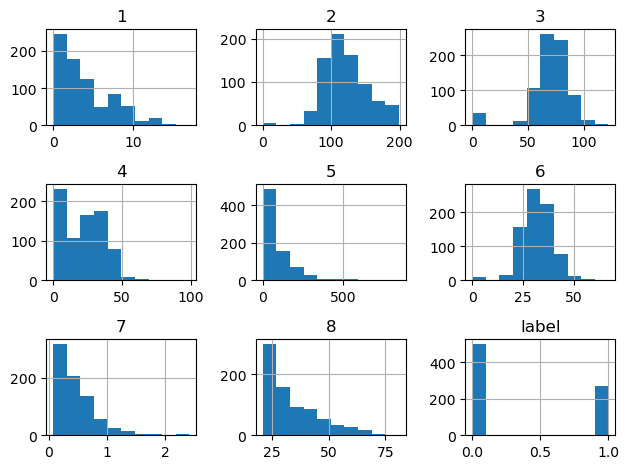

In [8]:
# check distribution 
df.hist()
plt.tight_layout()
plt.show()

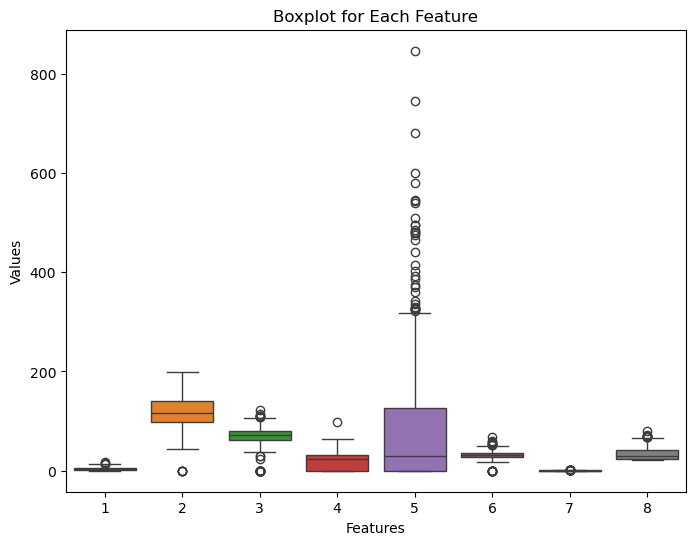

In [9]:
# find erroneous value
plt.figure(figsize=(8, 6))

sns.boxplot(data=df.iloc[:, :-1])

plt.title('Boxplot for Each Feature')
plt.xlabel('Features')
plt.ylabel('Values')

plt.xticks
plt.show()

In [10]:
# change erroneous value to nan
df.loc[(df[5]>400), 5] = nan
df.loc[(df[3]<30), 3] = nan
df.loc[(df[2]<20), 2] = nan
df.loc[(df[4]==99), 4] = nan
df.loc[(df[6]==0), 6] = nan

In [11]:
# check num of nan value
df.isnull().sum()

1         0
2         5
3        36
4         1
5        20
6        11
7         0
8         0
label     0
dtype: int64

In [12]:
# prepare preprocess pipeline
imputer = SimpleImputer(strategy='median')
standardscaler = StandardScaler()
preproc = Pipeline([('impute', imputer), ('scaler', standardscaler)])

In [13]:
# split the dataset
X = df.iloc[:,:-1]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [14]:
# prepare model
perceptron = Perceptron(random_state=42)
pipeline = Pipeline([('preproc', preproc), ('model', perceptron)])

In [15]:
# hyperparameter tuning
param_grid = {
    'model__max_iter': [100, 500, 1000],
    'model__tol': [1e-3, 1e-4, 1e-5],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall', verbose=1)

In [16]:
# training
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        Pipeline(steps=[('impute',
                                                         SimpleImputer(strategy='median')),
                                                        ('scaler',
                                                         StandardScaler())])),
                                       ('model', Perceptron(random_state=42))]),
             param_grid={'model__max_iter': [100, 500, 1000],
                         'model__tol': [0.001, 0.0001, 1e-05]},
             scoring='recall', verbose=1)

In [17]:
# best parameters
best_model = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)
# recall score on Val set
best_score = grid_search.best_score_
print("Best score: ", best_score)

Best parameters found:  {'model__max_iter': 100, 'model__tol': 0.001}
Best score:  0.41196013289036537


In [18]:
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("recall:", recall)

Accuracy: 0.7467532467532467
recall: 0.5185185185185185


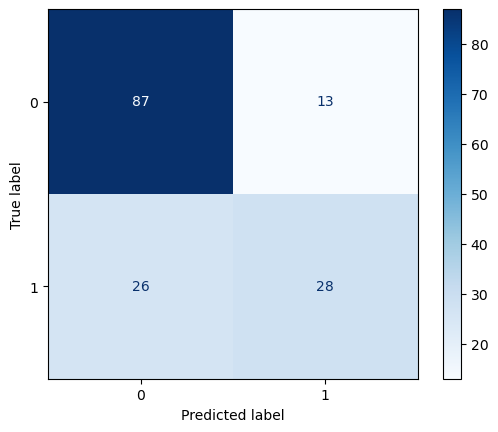

In [19]:
# plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()